# Lecture 16 Notebook

CSCI 3022, Fall 2023

[Acknowledgments Page](https://ds100.org/sp23/acks/)

In [1]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
adjust_fontsize(size=20)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Plotting helper functions.

In [2]:
# Helper functions to plot and 
# Compute expectation, variance, standard deviation
def plot_dist(dist_df,
                      xname="x", pname="P(X = x)", varname="X",
                      save=False, mean=False):
    """
    Plot a distribution from a distribution table.
    Single-variate.
    """
    expected_value = sum(dist_df[xname]*dist_df[pname])
    plt.bar(dist_df[xname], dist_df[pname])
    plt.ylabel(pname)
    plt.xlabel(xname)
    plt.title(f"Distribution of ${varname}$")
    plt.xticks(sorted(dist_df[xname].unique()))
    if mean==True:
        plt.scatter(expected_value, -0.015, marker='^', color='red', s=100)
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"dist{varname}.png", bbox_inches = 'tight');


def simulate_samples(df, xname="x", pname="P(X = x)", size=1):
    return np.random.choice(
                df[xname], # Draw from these choiecs
                size=size, # This many times
                p=df[pname]) # According to this distribution

def simulate_iid_df(dist_df, nvars, rows, varname="X"):
    """
    Make an (row x nvars) dataframe
    by calling simulate_samples for each of the nvars per row
    """
    sample_dict = {}
    for i in range(nvars):
        # Generate many datapoints 
        sample_dict[f"{varname}_{i+1}"] = \
            simulate_samples(dist_df, size=rows)
    return pd.DataFrame(sample_dict)


def plot_simulated_dist(df, colname, show_stats=True, save=False, **kwargs):
    """
    Plot a simulated population.
    """
    sns.histplot(data=df, x=colname, stat='probability', discrete=True, **kwargs)
    plt.xticks(sorted(df[colname].unique())) # if there are gaps)
    if show_stats:
        display(stats_df_multi(df, [colname]))
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"sim{colname}.png", bbox_inches = 'tight');

def stats_df_multi(df, colnames):
    means = df[colnames].mean(axis=0)
    variances = df[colnames].var(axis=0)
    stdevs = df[colnames].std(axis=0)
    df_stats = pd.concat([means, variances, stdevs],axis=1).T
    df_stats['index_col'] = ["E[•]", "Var(•)", "SD(•)"]
    df_stats = df_stats.set_index('index_col', drop=True).rename_axis(None)
    return df_stats

def plot_simulated_dist_multi(df, colnames, show_stats=True):
    """
    If multiple columns provided, use separate plots.
    """
    ncols = 1
    nrows = len(colnames)
    plt.figure(figsize=(6, 2*nrows+2))
    
    for i, colname in enumerate(colnames):
        subplot_int = int(100*int(nrows) + 10*int(ncols) + int(i+1))
        plt.subplot(subplot_int)
        plot_simulated_dist(df, colname, show_stats=False)
    plt.tight_layout()
    if show_stats:
        display(stats_df_multi(df, colnames))

In [3]:
from scipy.stats import expon

In [4]:
#P(X>1) when X~exp(.002)
# 1- P(X<=1)  Note:  Scale = 1/lambda

1-expon.cdf(1, scale=1/.002)

0.9980019986673331

In [5]:
from scipy.stats import norm

In [6]:
#X~N(4, 2)
#1-P(X<=6)
1-norm.cdf(6, loc=4, scale=np.sqrt(2))

0.07864960352514261

In [7]:
from scipy.stats import poisson

In [8]:
#P(X=0)  given X~Pois(0.002)
poisson.pmf(0, .002)

0.9980019986673332

---

## A Random Variable: Roulette Example

Roulette:  Let X be your winnings if you bet $1 on any particular number and play once.



In [5]:
# Our random variable X
dist_df = pd.DataFrame({"x": [-1, 35],
                        "P(X = x)": [37/38, 1/38]})
dist_df

,x,P(X = x)
0,-1,0.973684
1,35,0.026316


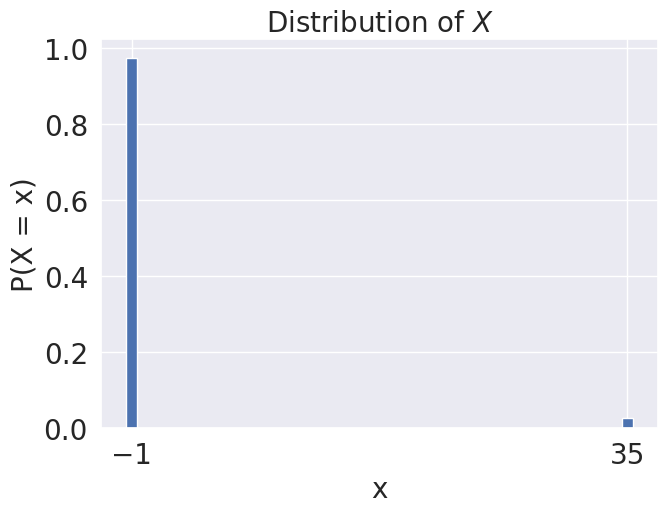

In [10]:
plot_dist(dist_df, save=True)

## Expected Value of X:

In [11]:
expected_value = (dist_df["x"]*dist_df["P(X = x)"]).sum()

expected_value


-0.052631578947368474

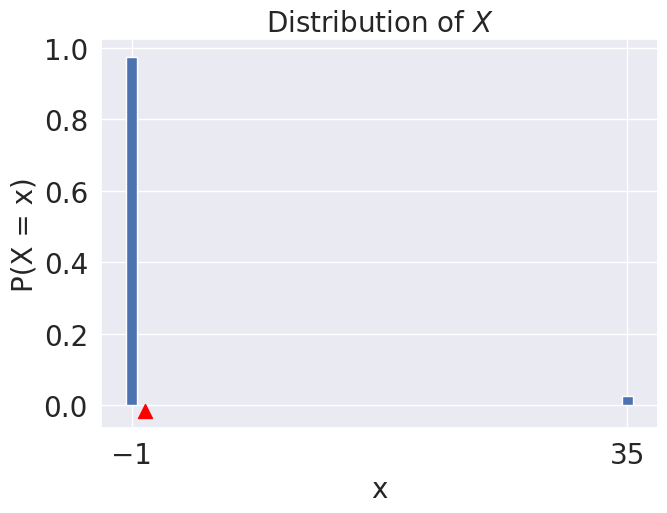

In [12]:
plot_dist(dist_df, save=True, mean=True)


## Variance and Standard Deviation of X:

In [13]:
var = ((dist_df["x"]-expected_value)**2*dist_df["P(X = x)"]).sum()

print ("Variance of X is ",var)

std = np.sqrt(var)

print ("Std deviation of X is ",std)

Variance of X is  33.20775623268698
Std deviation of X is  5.762617133966734


<br/><br/>

---

# Die Is the Singular; Dice Is the Plural

Let X be the outcome of a single die roll. X is a random variable.

In [14]:
# Our random variable X
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667


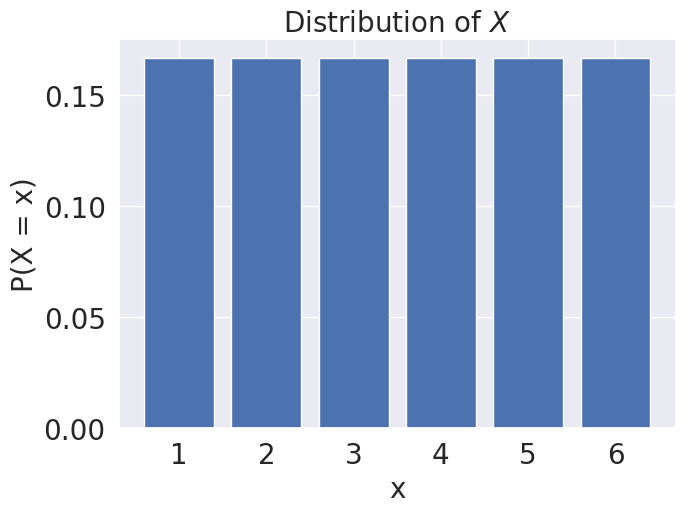

In [15]:
plot_dist(roll_df)

<br/><br/>

---

# Sum of 2 Dice Rolls

Here's the distribution of a single die roll:

In [16]:
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667


Let $X_1, X_2$ are the outcomes of two dice rolls. Note $X_1$ and $X_2$ are i.i.d. (independent and identically distributed).

Below I call a helper function `simulate_iid_df`, which simulates an 80,000-row table of $X_1, X_2$ values. It uses `np.random.choice(arr, size, p)` [link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) where `arr` is the array the values and `p` is the probability associated with choosing each value. If you're interested in the implementation details, scroll up.

In [17]:
N = 80000
sim_rolls_df = simulate_iid_df(roll_df, nvars=2, rows=N)
sim_rolls_df

,X_1,X_2
0,5,6
1,3,4
2,2,3
3,5,1
4,6,4
...,...,...
79995,4,5
79996,5,5
79997,1,2
79998,5,6


Define the following random variables, which are functions of $X_1$ and $X_2$:
* $Y = X_1 + X_1 = 2 X_1$
* $Z = X_1 + X_2$

We can use our simulated values of $X_1, X_2$ to create new columns $Y$ and $Z$:

In [18]:
sim_rolls_df['Y'] = 2 * sim_rolls_df['X_1']
sim_rolls_df['Z'] = sim_rolls_df['X_1'] + sim_rolls_df['X_2']
sim_rolls_df

,X_1,X_2,Y,Z
0,5,6,10,11
1,3,4,6,7
2,5,2,10,7
3,2,3,4,5
3,5,1,10,6
4,6,4,12,10
...,...,...,...,...
79995,4,5,8,9
79996,5,5,10,10
79997,1,2,2,3


Now that we have simulated samples of $Y$ and $Z$, we can plot histograms to see their distributions!

<br/>
Distribution of $Y$, which was twice the value of our first die roll:

,Y
E[•],7.003475
Var(•),11.696934
SD(•),3.420078


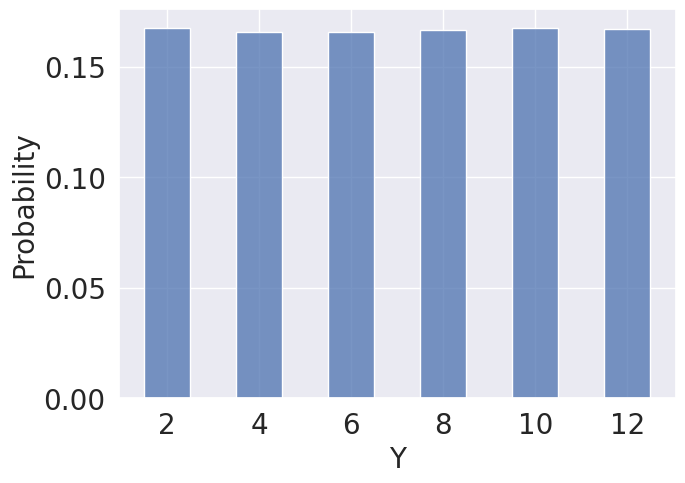

In [19]:
plot_simulated_dist(sim_rolls_df, "Y", save=True)

Distribution of $Z$, the sum of two IID dice rolls:

,Z
E[•],7.005138
Var(•),5.895710
SD(•),2.428108


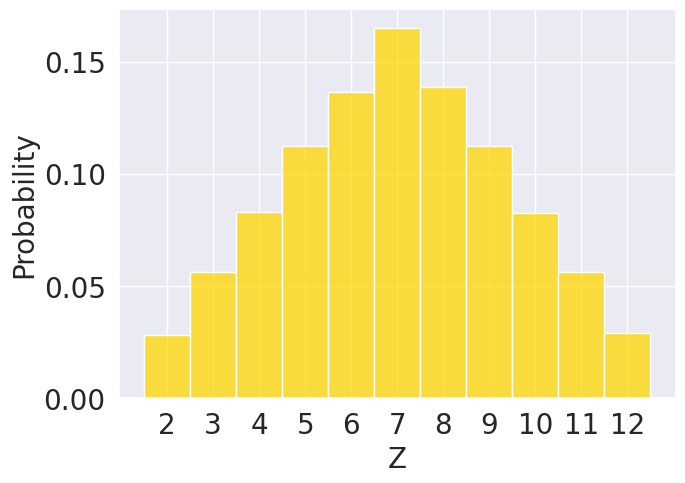

In [20]:
plot_simulated_dist(sim_rolls_df, "Z", save=True, color='gold')

Let's compare the expectations and variances of these simulated distributions of $Y$ and $Z$.
* We computed:
    * $\mathbb{E}[Y]$ as `np.mean(sim_rolls_df['Y'])`
    * $\text{Var}(Y)$ as `np.var(sim_rolls_df['Y']`
    * etc.
* The larger your simulated rows $N$, the closer the simulated expectation will be to the true expectation.
* Our approach is tedious--we have to simulate an entire population, then reduce it down to expectation/variance/standard deviation. It turns out we can calculate the Expected Value and Variance of linear sums of RV using properties of expected value and variance.  See the extra slides at the end of Lec 16 for details!

In [21]:
stats_df_multi(sim_rolls_df, ["Y", "Z"])

,Y,Z
E[•],7.003475,7.005138
Var(•),11.696934,5.895710
SD(•),3.420078,2.428108


<br/><br/>

---

# Which would you pick?

* $\large Y_A = 10 X_1 + 10 X_2 $
* $\large Y_B = \sum\limits_{i=1}^{20} X_i$
* $\large Y_C = 20 X_1$

First let's construct the probability distribution for a single coin. This will let us flip 20 IID coins later.

In [22]:
# First construct probability distribution for a single fair coin
p = 0.5
coin_df = pd.DataFrame({"x": [0, 1], # [Tails, Heads]
                        "P(X = x)": [p, 1 - p]})
coin_df

,x,P(X = x)
0,0,0.5
1,1,0.5


## Choice A:
$\large Y_A = 10 X_1 + 10 X_2 $

In [23]:
# Flip 20 iid coins, each exactly once
flips20_df = simulate_iid_df(coin_df, nvars=20, rows=1)

# Construct Y_A from this sample
flips20_df["Y_A"] = 10*flips20_df["X_1"] + 10*flips20_df["X_2"]

print("Sample of size 1:")
display(flips20_df)
print("Y_A:", flips20_df.loc[0,"Y_A"])

Sample of size 1:


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,Y_A
0,1,0,0,0,0,1,0,1,0,1,...,1,1,1,1,1,1,0,1,1,10


Y_A: 10


## Choice B:

$\large Y_B = \sum\limits_{i=1}^{20} X_i$

In [24]:
# Flip 20 iid coins, each exactly once
flips20_df = simulate_iid_df(coin_df, nvars=20, rows=1)

# Construct Y_B from this sample
flips20_df["Y_B"] = flips20_df.sum(axis=1) # sum all coins

display(flips20_df)
print("Y_B:", flips20_df.loc[0,"Y_B"])

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,Y_B
0,0,1,0,0,0,1,0,1,1,1,...,1,1,0,1,0,0,0,1,0,10


Y_B: 10


## Choice C:

$\large Y_C = 20 X_1$

In [25]:
# Flip 20 iid coins, each exactly once
flips20_df = simulate_iid_df(coin_df, nvars=20, rows=1)

# Construct Y_C from this sample
flips20_df["Y_C"] = 20*flips20_df["X_1"]

display(flips20_df[["X_1", "Y_C"]])
print("Y_C:", flips20_df.loc[0,"Y_C"])

,X_1,Y_C
0,1,20


Y_C: 20


<br/>
If you're curious as to what these distributions look like, I've simulated some populations:

80000 simulated samples


,Y_A,Y_B,Y_C
E[•],9.987500,9.991350,12.504500
Var(•),50.027969,5.027713,56.250683
SD(•),7.073045,2.242256,7.500046


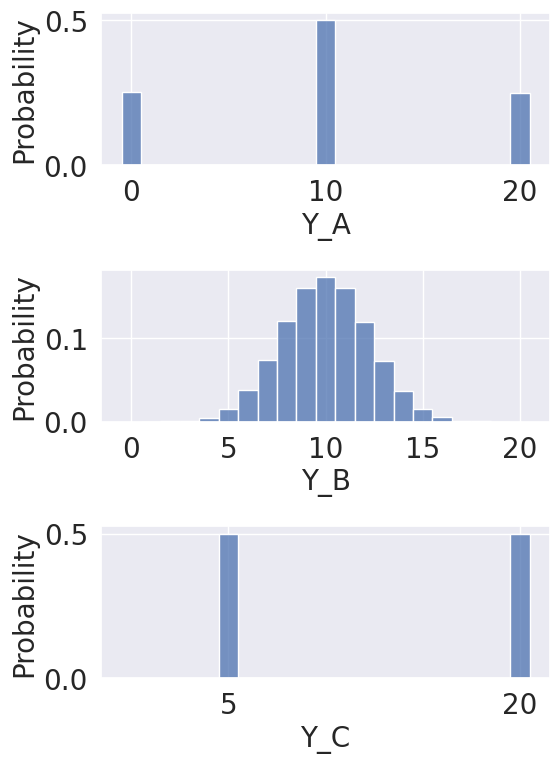

In [26]:
# Simulate one big population of 20 fair flips, N = 80,000
N = 80000
df_coins = simulate_iid_df(coin_df, nvars=20, rows=N)
print(f"{N} simulated samples")


# construct Y_A, Y_B, Y_C from this population
df_coins["Y_A"] = 10*df_coins["X_1"] + 10*df_coins["X_2"]
df_coins["Y_B"] = df_coins.loc[:,"X_1":"X_20"].sum(axis=1)
df_coins["Y_C"] = 5 + 15*df_coins["X_1"]
plot_simulated_dist_multi(df_coins, ["Y_A", "Y_B", "Y_C"])

# adjust axes for nicer plotting
axs = plt.gcf().axes
axs[1].set_xlim(axs[0].get_xlim())    # Y_B
axs[1].set_xticks([0, 5, 10, 15, 20]) # Y_B
axs[2].set_xlim(axs[0].get_xlim())    # Y_C
plt.show()

<br/><br/>

If we flipped 100 coins, look how beautiful the Binomial distribution looks:

,Y_100
E[•],25.028950
Var(•),12.502968
SD(•),3.535954


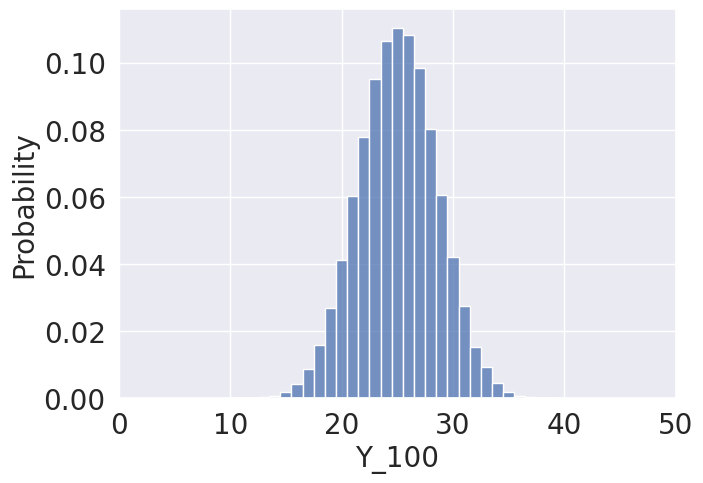

In [27]:
# Simulate one big population of 100 fair flips, N = 80,000
N = 80000
df_coins = simulate_iid_df(coin_df, nvars=50, rows=N)
df_coins["Y_100"] = df_coins.loc[:,"X_1":"X_50"].sum(axis=1)
plot_simulated_dist(df_coins, "Y_100")
plt.xticks([0, 10, 20, 30, 40, 50])
plt.show()

<br/><br/><br/>

---

# From Population to Sample

Remember the population distribution we looked at earlier:

In [28]:
dist_df

,x,P(X = x)
0,-1,0.973684
1,35,0.026316


In [29]:
(4/5)*(3/4)/((4/5)*(3/4)+(1/4)*(2/5))

,X(s)
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
99995,-1
99996,-1
99997,-1
99998,-1


In [30]:
3/7

,X
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
95,-1
96,-1
97,-1
98,35


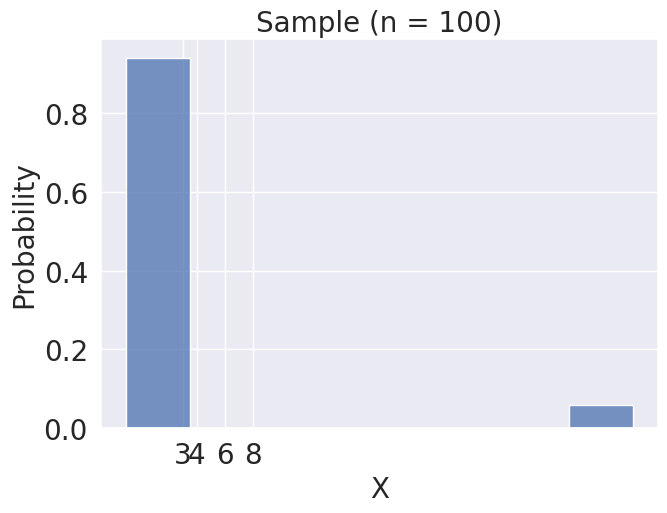

Mean of Sample: 1.16


In [31]:
sns.histplot(data=sample_df, x='X', stat='probability')
plt.xticks([3, 4, 6, 8])
plt.title(f"Sample (n = 100)")
plt.show()

print("Mean of Sample:", np.mean(sample_df['X']))

<br/>

Compare this to our **original population** (N = 80,000):

In [32]:
plot_simulated_dist(sim_df, "X(s)")
plt.title("Population of $X$")
plt.show()

NameError: name 'sim_df' is not defined